## SEFA : Closed-Form Factorization of Latent Semantics in GANs (CVPR 2021)

- [`Happy-jihye`](https://github.com/happy-jihye)
- reference : [`rosinality/stylegan2-pytorch`](https://github.com/rosinality/stylegan2-pytorch)


In [26]:
import torch, os
import cv2 
import numpy as np
import PIL.Image as pilimg
import matplotlib.pyplot as plt
import imageio

from model import Generator

import ipywidgets as widgets
from ipywidgets import VBox

In [17]:
def image2tensor(image):
    image = torch.FloatTensor(image).permute(2,0,1).unsqueeze(0)/255.
    return (image-0.5)/0.5

def tensor2image(tensor):
    tensor = tensor.clamp_(-1., 1.).detach().squeeze().permute(1,2,0).cpu().numpy()
    return tensor*0.5 + 0.5

def imshow(img, size=5, cmap='jet'):
    plt.figure(figsize=(size,size))
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.show()

def save_image(img, size=5, out='output.png' , cmap='jet'):
    plt.figure(figsize=(size*3,size))
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.savefig(out, dpi=300)

### Generator

You can download Cartoon-StyleGAN checkpoints in [here](https://github.com/happy-jihye/Cartoon-StyleGAN) !

In [8]:
device='cuda'

# Genearaotr1
network1 = 'networks/550000.pt'
network1 = torch.load(network1)

g1 = Generator(256, 512, 8, channel_multiplier=2).to(device)
g1.load_state_dict(network1["g_ema"], strict=False)
truncation = 0.7
trunc1 = g1.mean_latent(4096).detach().clone()


# Generator2
network2 = 'networks/Romance101.pt'
network2 = torch.load(network2)

g2 = Generator(256, 512, 8, channel_multiplier=2).to(device)
g2.load_state_dict(network2["g_ema"], strict=False)
trunc2 = g2.mean_latent(4096).detach().clone()

### Closed-Form Factorization 

```bash
#factor.pt
python3 closed_form_factorization.py networks/550000.pt
```

In [9]:
# Eigen-Vector
factor='factor.pt'
eigvec = torch.load(factor)["eigvec"].to(device)


seed = widgets.IntSlider(value=775580, min=0,max=1000000, step=1, description='seed:')
degree = widgets.FloatSlider(value=0, min=-10,max=10,step=0.5, description='degree:')
index = widgets.IntSlider(value=7, min=0,max=10,step=1, description='index:')

ui = widgets.VBox([seed, index, degree])


def generate(seed, index, degree):
    torch.manual_seed(seed)
    latent = torch.randn(1, 14, 512, device=device)
    latent = g1.get_latent(latent)

    direction = degree * eigvec[:, index].unsqueeze(0) #torch.Size([1, 512])
    
    img1_ori, _ = g1(
      [latent],
      truncation=truncation,
      truncation_latent=trunc2,
      input_is_latent=True,
    )    
    
    img1, _ = g1(
      [latent + direction],
      truncation=truncation,
      truncation_latent=trunc2,
      input_is_latent=True,
    )
    
    img2_ori, _ = g2(
      [latent],
      truncation=truncation,
      truncation_latent=trunc2,
      input_is_latent=True,
    )
    
    img2, _ = g2(
      [latent + direction],
      truncation=truncation,
      truncation_latent=trunc2,
      input_is_latent=True,
    )
    
    
    return imshow(tensor2image(torch.cat([img1_ori[0], img1[0], img2_ori[0], img2[0]], dim=2)), 20)


out = widgets.interactive_output(generate, {'seed':seed, 'index':index, 'degree':degree})

tab  = widgets.Tab(children = [out])
tab.set_title(0, 'generator')

display(ui,tab)


### Make GIF

In [32]:
# Eigen-Vector
factor='factor.pt'
eigvec = torch.load(factor)["eigvec"].to(device)

torch.manual_seed(seed.value)
latent = torch.randn(1, 14, 512, device=device)
latent = g1.get_latent(latent)
   
degree = 10

images = []
for deg in range(degree):

    direction = deg * eigvec[:, index.value].unsqueeze(0) #torch.Size([1, 512])
    
    img1_ori, _ = g1(
      [latent],
      truncation=truncation,
      truncation_latent=trunc2,
      input_is_latent=True,
    )    
    
    img1, _ = g1(
      [latent + direction],
      truncation=truncation,
      truncation_latent=trunc2,
      input_is_latent=True,
    )
    
    img2_ori, _ = g2(
      [latent],
      truncation=truncation,
      truncation_latent=trunc2,
      input_is_latent=True,
    )
    
    img2, _ = g2(
      [latent + direction],
      truncation=truncation,
      truncation_latent=trunc2,
      input_is_latent=True,
    )
    
    
    images.append(tensor2image(torch.cat([img1_ori[0], img1[0], img2_ori[0], img2[0]], dim=2)))
    

In [33]:
speed_sec = { 'duration': 0.2 } #사진 넘기는 시간

imageio.mimsave('sefa.gif', images, **speed_sec)

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

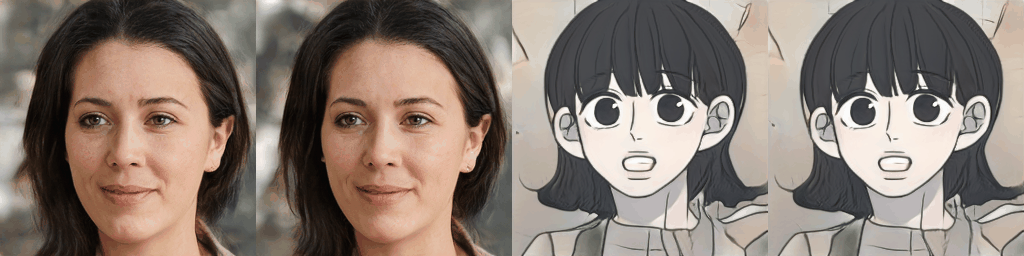

In [34]:
from IPython.display import Image
Image(open('sefa.gif','rb').read())